In [3]:
import sys 
import os
import cymetric as cym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from cymetric import graphs as cgr
from cymetric import timeseries as tm
import cymetric
import pyne
pd.options.display.precision = 16

%matplotlib inline

In [4]:
### weak point....need to have these variables in a file that input + analysis both use ###
add_intro = 12*5
trans_sfr = 12*30

impt_times = [add_intro, trans_sfr]

In [11]:
#db = cym.dbopen('../output/01_full-add_flat-pwr.sqlite')
#db = cym.dbopen('../output/01_full-add_grow-pwr.sqlite')
#db = cym.dbopen('../output/01_ramp-add_flat-pwr.sqlite') # not working, sim fails
#db = cym.dbopen('../output/01_ramp-add_grow-pwr.sqlite') # not working, sim fails
#db = cym.dbopen('../output/23_full-add_flat-pwr.sqlite')
db = cym.dbopen('../output/eg23_grow_175000000_2500000.sqlite') # not working, bad power curve
ev = cym.Evaluator(db=db, write=False)

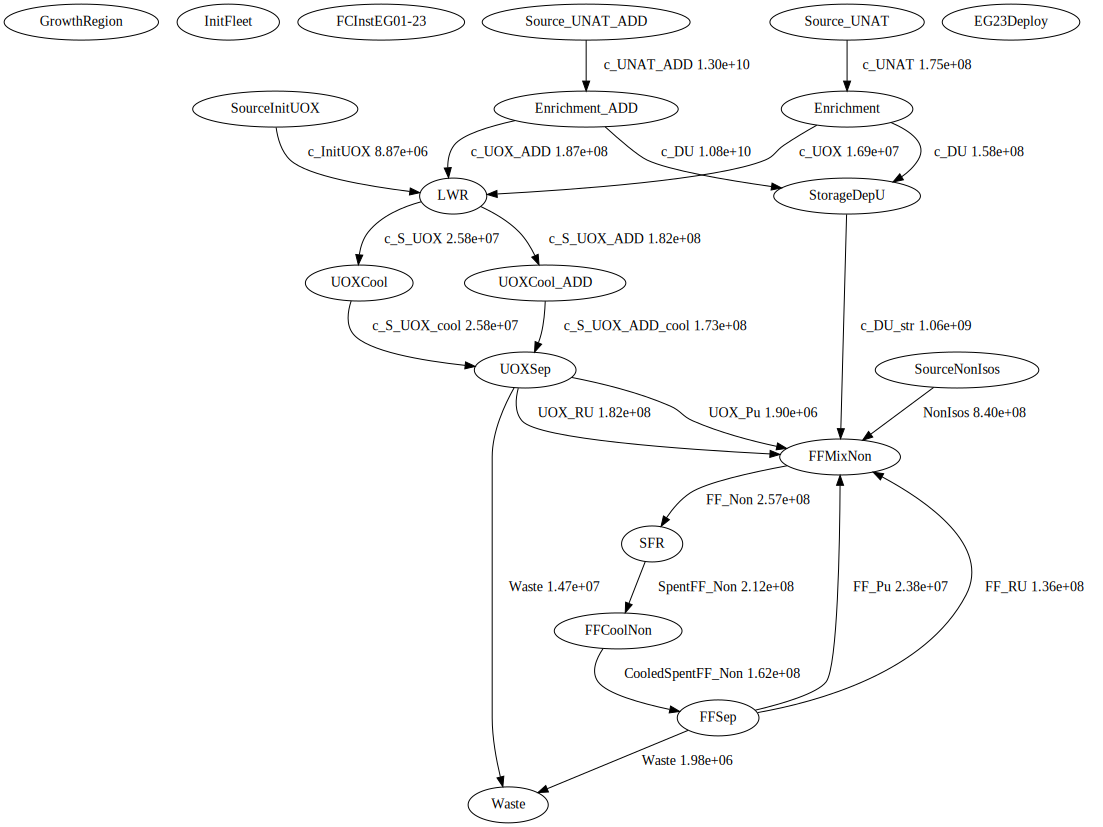

In [12]:
d = cgr.flow_graph(ev, label=['com', 'mass'], start=0)
#d.render('eg23',format='png', view=True)
d

# Time Series Power

In [17]:
trans_sfr = 12*30

def pwr_plt(dfs):
    ax = dfs[0].plot(x='Year', figsize=(9,5), legend=False)

    
    for df in dfs[1:]:
        df.plot(x='Year', figsize=(9,5), legend=False, ax=ax)
    plt.xlabel(r'Year', fontsize=20)
    plt.ylabel(r'Power [GWe]',fontsize=20)
    ax.minorticks_on()
    #ax.set_ylim(-9, 281)
    #ax.set_xlim(0, 100)
    ax.minorticks_on()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.tick_params(labelsize=18)
    plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
    plt.grid()
    plt.show()
    return

def tr_plt(dfs, label=r'Transaction [t]'):
    ax = dfs[0].plot(x='Year', y='Mass', figsize=(9,5), legend=False)

    
    for df in dfs[1:]:
        df.plot(x='Year', y='Mass', figsize=(9,5), legend=False, ax=ax)
    plt.xlabel(r'Year', fontsize=20)
    plt.ylabel(label,fontsize=20)
    ax.minorticks_on()
    #ax.set_ylim(-9, 281)
    #ax.set_xlim(0, 100)
    ax.minorticks_on()
    ax.set_xticks(np.arange(0, 100, 10))
    ax.tick_params(labelsize=18)
    plt.axvline(x=trans_sfr/12., color='k', linestyle='--')
    plt.grid()
    plt.show()
    return

/root/.local/lib/python3.6/site-packages/cymetric/timeseries.py:197: UserWarning: no faciity provided
  warnings.warn(wng_msg, UserWarning)


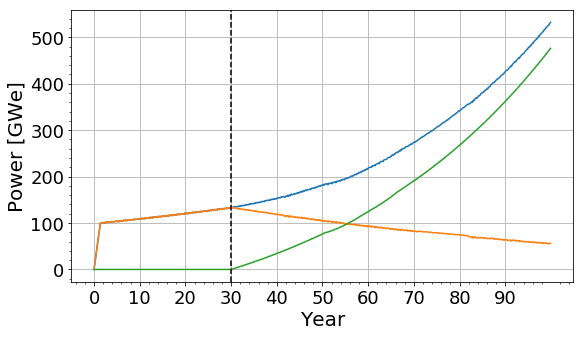

In [18]:
df_tspower = tm.get_power(ev, [])
df_tspower1 = tm.get_power(ev, ['LWR'])
df_tspower2 = tm.get_power(ev, ['SFR'])
df_tspower['Year'] = df_tspower['Time'] / 12.
df_tspower1['Year'] = df_tspower1['Time'] / 12.
df_tspower2['Year'] = df_tspower2['Time'] / 12.
# power in GWe
power = df_tspower.groupby(['Year'])['Value'].sum() / 1000.0
power1 = df_tspower1.groupby(['Year'])['Value'].sum() / 1000.0
power2 = df_tspower2.groupby(['Year'])['Value'].sum() / 1000.0
pwr_plt([power, power1, power2])


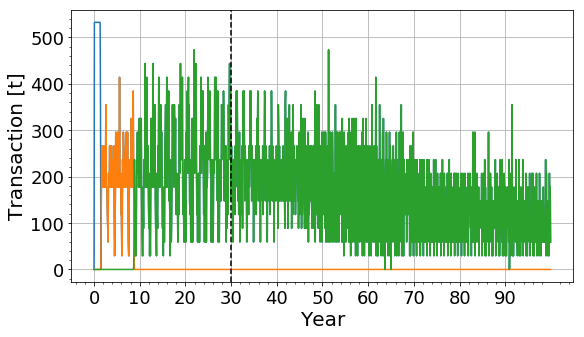

In [19]:
df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
df_tr_PWR['Mass'] = df_tr_PWR['Mass']/1000.
df_tr_PWR_unat = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment'])
df_tr_PWR_unat['Mass'] = df_tr_PWR_unat['Mass']/1000.
df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'])
df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/1000.


df_tr_PWR['Year'] = df_tr_PWR['Time'] / 12.
df_tr_PWR_unat['Year'] = df_tr_PWR_unat['Time'] / 12.
df_tr_PWR_unat_add['Year'] = df_tr_PWR_unat_add['Time'] / 12.

tr_plt([df_tr_PWR, df_tr_PWR_unat, df_tr_PWR_unat_add])


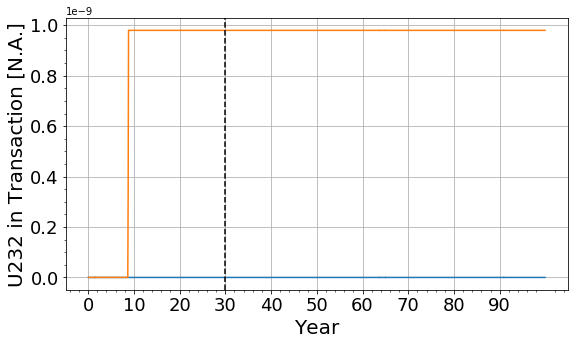

In [20]:
df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
df_tr_PWR['Mass'] = df_tr_PWR['Mass']
df_tr_PWR_unat = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment'], nucs=['922320000'])
df_tr_PWR_unat['Mass'] = df_tr_PWR_unat['Mass']/df_tr_PWR['Mass']
df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'], nucs=['922320000'])
df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/df_tr_PWR['Mass']


df_tr_PWR['Year'] = df_tr_PWR['Time'] / 12.
df_tr_PWR_unat['Year'] = df_tr_PWR_unat['Time'] / 12.
df_tr_PWR_unat_add['Year'] = df_tr_PWR_unat_add['Time'] / 12.

tr_plt([df_tr_PWR_unat, df_tr_PWR_unat_add], label=r'U232 in Transaction [N.A.]')




In [21]:
def ratio_until(pdf, time=100):
    max_value = pdf['Mass'].max()
    pdf_transition = pdf[pdf['Time'] < time]
    return pdf_transition['Mass'].mean()/max_value

def found_equilibrium(pdf, full_load):
    eq_year = -1
    not_eq = pdf[pdf['Mass'] != full_load['Mass']]['Time']
    return not_eq.max()+1


def get_transition_ratio(output_file):
    db = cym.dbopen(output_file)
    ev = cym.Evaluator(db=db, write=False)

    df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
    df_tr_PWR['Mass'] = df_tr_PWR['Mass']/1000.
    df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'])
    df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/1000.    
    eq_time = found_equilibrium(df_tr_PWR_unat_add, df_tr_PWR)

    
    df_tr_PWR = tm.transactions(ev, receivers=['LWR'])
    df_tr_PWR_unat_add = tm.transactions(ev, receivers=['LWR'], senders=['Enrichment_ADD'], nucs=['922320000'])
    df_tr_PWR_unat_add['Mass'] = df_tr_PWR_unat_add['Mass']/df_tr_PWR['Mass']
    ratio = ratio_until(df_tr_PWR_unat_add, eq_time)
    
    return eq_time, ratio


blend_list = [2.5e7, 5e7, 7.5e7, 1e8, 1.75e8, 2.5e8, 3.75e8, 5e8]
throughput_list = [2.5e5, 5e5, 7.5e5, 1e6, 1.25e6, 1.75e6, 2.5e6]

output = []
time = []
ratio = []
for i, blend in enumerate(blend_list):
    for j, throughput in enumerate(throughput_list):
        output_str = "../output/eg23" + "_grow_" + str(int(blend)) + "_" + str(int(throughput)) +'.sqlite'
        trans_ratio = get_transition_ratio(output_str)
        output.append((blend, throughput, trans_ratio))
        time.append(trans_ratio[0])
        ratio.append(trans_ratio[1])
        print(blend, throughput, trans_ratio)

25000000.0 250000.0 (18, 0.0)
25000000.0 500000.0 (60, 0.46146688560481658)
25000000.0 750000.0 (43, 0.25629113433991485)
25000000.0 1000000.0 (35, 0.12121212121212122)
25000000.0 1250000.0 (32, 0.027777777777777766)
25000000.0 1750000.0 (32, 0.027777777777777759)
25000000.0 2500000.0 (32, 0.027777777777777762)
50000000.0 250000.0 (18, 0.0)
50000000.0 500000.0 (111, 0.55127410815484201)
50000000.0 750000.0 (76, 0.37498927498927487)
50000000.0 1000000.0 (60, 0.23639846743295015)
50000000.0 1250000.0 (50, 0.11760085978835977)
50000000.0 1750000.0 (45, 0.019933554817275743)
50000000.0 2500000.0 (44, 0.0)
75000000.0 250000.0 (18, 0.0)
75000000.0 500000.0 (160, 0.58652088066645025)
75000000.0 750000.0 (111, 0.43141575549832423)
75000000.0 1000000.0 (85, 0.30112354178619233)
75000000.0 1250000.0 (70, 0.17463818860877681)
75000000.0 1750000.0 (58, 0.0053571428571428563)
75000000.0 2500000.0 (58, 0.0071428571428571418)
100000000.0 250000.0 (18, 0.0)
100000000.0 500000.0 (210, 0.601574653978500

In [22]:
import math
import matplotlib.colors as colors
import numpy as np

x_blend = [x[0]/1000 for x in output]
thr_blend = [x[1]*7.923 for x in output]
thr_colors = np.array([x[1]*7.923 for x in output])
blend_colors = np.array([x[0]/1000 for x in output])
time_y = [x/12. for x in time]


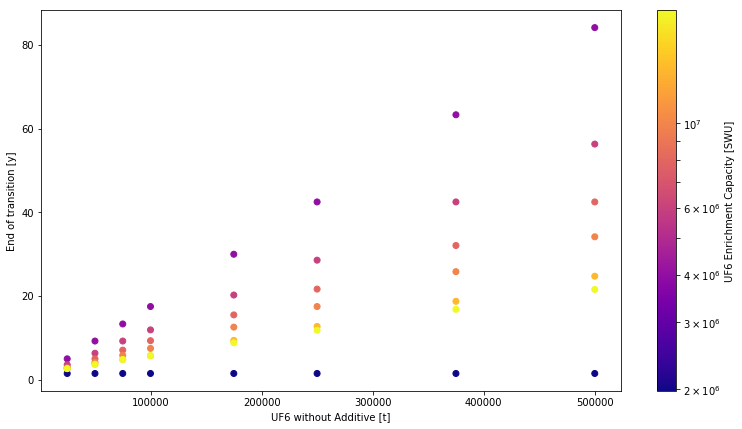

In [23]:
fig, ax = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 without Additive [t]")
plt.ylabel("End of transition [y]")
z_colors = thr_colors
sp = ax.scatter(x=x_blend, y=time_y, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar =fig.colorbar(sp, label="UF6 Enrichment Capacity [SWU]")
#tt = cbar.ax.set_yticklabels(['', '', '5e5', '','', '', '', '1e6','2e6'])

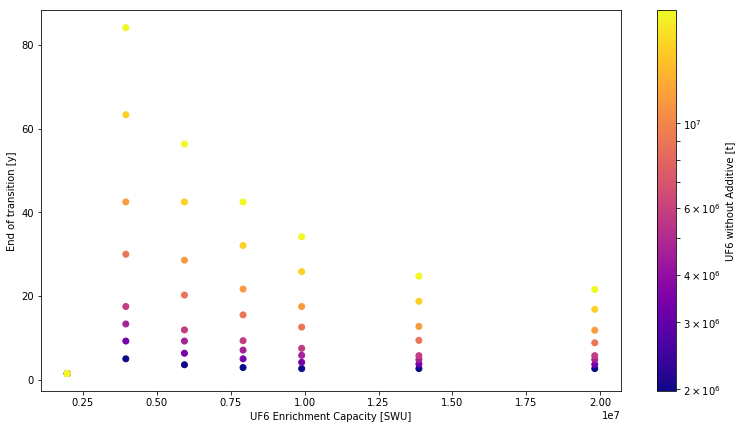

In [24]:
fig, ax_b = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 Enrichment Capacity [SWU]")
plt.ylabel("End of transition [y]")
z_colors = blend_colors
ax_b.scatter(x=thr_blend, y=time_y, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar =fig.colorbar(sp, label='UF6 without Additive [t]')
#tt = cbar.ax.set_yticklabels(['', '', '5e5', '','', '', '', '1e6','2e6'])

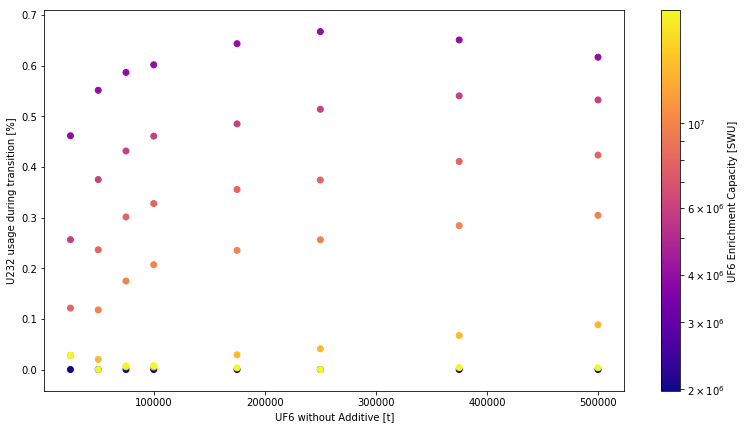

In [25]:

fig, ax2 = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 without Additive [t]")
plt.ylabel("U232 usage during transition [%]")
z_colors = thr_colors

ax2.scatter(x=x_blend, y=ratio, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar =fig.colorbar(sp, label="UF6 Enrichment Capacity [SWU]")
#tt = cbar.ax.set_yticklabels(['', '', '5e5', '','', '', '', '1e6','2e6'])

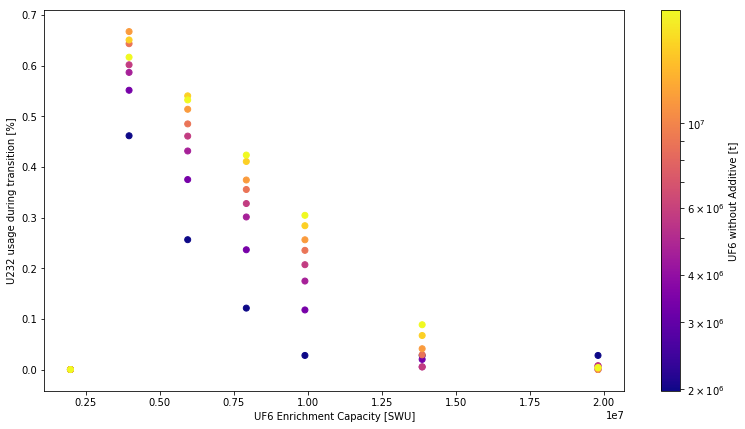

In [26]:
fig, ax2_b = plt.subplots(figsize=(13,7))
plt.xlabel("UF6 Enrichment Capacity [SWU]")
plt.ylabel("U232 usage during transition [%]")
z_colors = blend_colors

ax2_b.scatter(x=thr_blend, y=ratio, c=z_colors, norm=colors.LogNorm(vmin=z_colors.min(), vmax=z_colors.max()), cmap='plasma')
cbar =fig.colorbar(sp, label='UF6 without Additive [t]')
